# HW6: Supervised Machine Learning - Homebrew Computer Vision

In this assignment, we are to build a **random forest classifier** that takes as input one of the given images and classifies into 1 of the 50 catigories (built from the provided training dataset, found [here](https://www.dropbox.com/s/cst9awcjpp08k33/50_categories.tar.gz) using 36 (out of 50) computed features.

Question to consider: 
1. How much better is this than the expectation with random guessing?
2. What are the 3 most important features?

**The final classifier to be run on any directory with images to be classified can be found in the last cell of this document that looks like:**

In [1]:
# run_final_classifier("img_dir = /some directory")

First import neccessary packages.

In [2]:
# A must for array mulnipulations
import numpy as np

# Systematic operation/interaction 
import os
import pickle

# multiprocessing for speed ups
from multiprocessing import Pool, cpu_count

# Image feature extraction
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_peaks, blob_doh, blob_dog
from skimage.segmentation import quickshift

# A fast, extensible smart progress meter
from tqdm import tqdm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_color_codes()
sns.set_context('poster')
%matplotlib inline

## Global Variables & Paths setting

In [3]:
trainning_set = './50_categories/'

In [4]:
image_paths = []
for cat in os.listdir(trainning_set):
    cat_path = os.path.join(trainning_set, cat)
    for img in os.listdir(cat_path):
        image_paths.append(os.path.join(cat_path, img))

In [5]:
def label_from_path(path):
    """Extract the name/labels of the path"""
    return path.split('/')[-2]

In [6]:
def category_paths(category):
    """Get images under same category based on their paths"""
    return list(filter(lambda x: category == label_from_path(x), image_paths))

## Feature Selection

Before extracting features from images, writing a few complementary functions would assist us better understand and digest observable and hidden information in the images.
### Size
Images under difference categories have different sizes. Some categories have smaller sized images than others.

In [7]:
def img_size(img):
    """Get the size of an image array in megapixels"""
    return np.prod(img.shape[:2])/1e6

### Orientation
Images under certain categories tend to be in certain orientation (portrait, landscape). For instance, most images under "airplanes" are in landscape shapes.

In [8]:
def orientation(img):
    """Calculate aspect ratio height/width from (H x W x 3) RGB image array"""
    return img.shape[0]/img.shape[1]

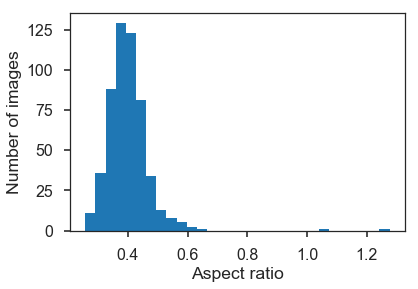

In [9]:
plane_ori = []
for p in category_paths('airplanes'):
    img = imread(p)
    plane_ori.append(orientation(img))

plt.xlabel("Aspect ratio");
plt.ylabel("Number of images");
plt.hist(plane_ori, bins=30); # add ; to avoid printing arrays

When the height/width ratio equals to 1.0, the image is in square shape. When the value is less than 1.0, meaning the height is smaller than the width, images with such value are in landscape shapes.

Here, we see almost all images have ratio smaller than 0.65 (by observation), with very few outliers. This proves "orientation" to be a valid and meaningful feature.

### Color Statistics
Images under different categories usually have different color patterns, leading to different statistics for colored pixel values. The overall color pattern of an image could tell us what the image can be about. For instance, images of swan have more pixels in "white" whereas those of leopards have more pixels in "yellow" or "brown" and "black" (in greyscale), though these colors are expressed as combinations of different volumns of red/green/blue. 

In [10]:
def color_stats(img, color):
    """
    Calculate the average, standard deviation and ranges of pixel values
    in color r - red, g - green, b - blue, or in z for an image array
    """
    if color.lower() == 'z' or len(img.shape) < 3:
        img = rgb2gray(img)
        ave = np.mean(img) # the mean value shows the tone of the image
        std = np.std(img) # the std value shows the color contrast
        ran = np.max(img) - np.min(img) # range tells the color range
        return ave, std, ran
    color_index = ['r', 'g', 'b'].index(color.lower())
    ave = np.mean(img[:, :, color_index])
    std = np.std(img[:, :, color_index])
    ran = np.max(img[:, :, color_index])-np.min(img[:, :, color_index])
    return ave, std, ran

In [11]:
def color_ratio(img, color1, color2):
    """Find the ratio of mean values across two colors"""
    ave1, _, _ = color_stats(img, color1)
    ave2, _, _ = color_stats(img, color2)
    return ave1/ave2

In [12]:
def color_diff(img, color1, color2):
    """Calculate the difference between mean values of two colors"""
    ave1, _, _ = color_stats(img, color1)
    ave2, _, _ = color_stats(img, color2)
    return ave1-ave2

To validify the feature, let us examine the feature performance.

In [13]:
swan_r, swan_g, swan_b = [], [], []
leopards_r, leopards_g, leopards_b = [], [], []
for p in category_paths('swan'):
    img = imread(p)
    swan_r.append(color_stats(img, 'r'))
    swan_g.append(color_stats(img, 'g'))
    swan_b.append(color_stats(img, 'b'))
for p in category_paths('leopards'):
    img = imread(p)
    leopards_r.append(color_stats(img, 'r'))
    leopards_g.append(color_stats(img, 'g'))
    leopards_b.append(color_stats(img, 'b'))

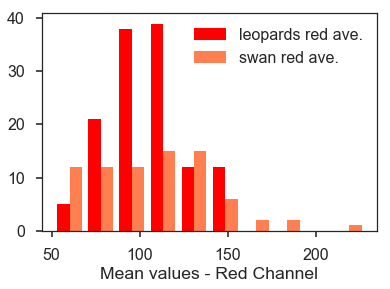

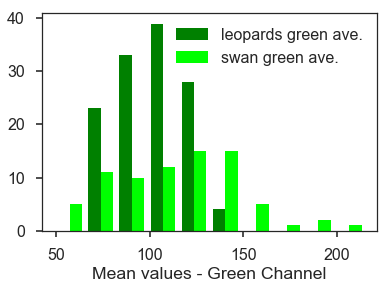

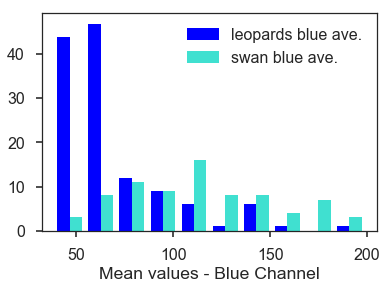

In [14]:
# Empirical Distribution of red channel mean values
plt.hist([list(zip(*leopards_r))[0], list(zip(*swan_r))[0]], color=['red', 'coral'], label=['leopards red ave.', 'swan red ave.']);
plt.xlabel("Mean values - Red Channel");
plt.legend();
plt.show();

# Empirical Distribution of green channel mean values
plt.hist([list(zip(*leopards_g))[0], list(zip(*swan_g))[0]], color=['green', 'lime'], label=['leopards green ave.', 'swan green ave.']);
plt.xlabel("Mean values - Green Channel");
plt.legend();
plt.show();

# Empirical Distribution of blue channel mean values
plt.hist([list(zip(*leopards_b))[0], list(zip(*swan_b))[0]], color=['blue', 'turquoise'], label=['leopards blue ave.', 'swan blue ave.']);
plt.xlabel("Mean values - Blue Channel");
plt.legend();
plt.show();

### Color Position & Cross-Correlation & Saturation
The location of and distances between minimum and maximum pixel values in certain color channel can be informative such as a group of "black" pixels (in greyscale) surrounded by a larger group of "yellow" pixels (in greyscale) can imply that the image might be a leopard. The cross-correlations between colored pixels and ratio of saturated pixels may also be found useful. 

However, since we are designing features by hand rather than architecture by hand, we could not verify the importance of such features. As the writer of this classifer, I make the judgement call that it should help in some way, especially in differentiating objects with close color compositions. 

In [15]:
def min_max_color_position(img, color):
    """
    Find the x, y location of the maximum pixel value of the
    given color, normalized by the shape of the image.
    """
    if color.lower() == 'z' or len(img.shape) < 3:
        img = rgb2gray(img)
        min_y, min_x = np.unravel_index(np.argmin(img), img.shape)
        max_y, max_x = np.unravel_index(np.argmax(img), img.shape)
        return min_x, min_y, max_x, max_y
    color_index = ['r', 'g', 'b'].index(color.lower())
    min_y, min_x = np.unravel_index(np.argmin(img[:, :, color_index]), img[:, :, color_index].shape)
    max_y, max_x = np.unravel_index(np.argmax(img[:, :, color_index]), img[:, :, color_index].shape)
    return min_x/img.shape[1], min_y/img.shape[0], max_x/img.shape[1], max_y/img.shape[0]

In [16]:
def min_max_distance(img, color):
    """Find the distance between the minimum and maximum pixel values"""
    minx, miny, maxx, maxy = min_max_color_position(img, color)
    return np.sqrt((maxx-minx)**2+(maxy-miny)**2)

In [17]:
def color_xcorr(img, color1, color2):
    """Calculate the correlations of two colors' values"""
    if len(img.shape) < 3:
        return 0.
    color_index1 = ['r', 'g', 'b'].index(color1.lower())
    color_index2 = ['r', 'g', 'b'].index(color2.lower())
    return np.corrcoef(np.array([img[:, :, color_index1].flatten(), img[:, :, color_index2].flatten()]))[0, 1]

In [18]:
def saturation(img, threshold=0.01):
    """Calculate the fraction of black/white pixels below/above threshold"""
    img2 = rgb2gray(img)
    below = len(list(zip(*np.where(img2 < threshold))))/img_size(img)
    above = len(list(zip(*np.where(img2 > (1-threshold)))))/img_size(img)
    return below, above

### Harris Corner Detection
Referring to [OpenCV's documentation on Harris Corner](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html), Harris Corner Detection method can help find the number of corners in an (normalized) image and differentiate images (categories of images) having fewer sharp corners.

In [19]:
def harris_corners(img):
    """Calculate the number of corner points using Harris corner detection"""
    if img.shape[-1]==3:
        img = rgb2gray(img)
    n = len(corner_peaks(corner_harris(img)))
    return n/img_size(img)   # normalize by image size

Feature performance examination, using categories: swan & leopards again.

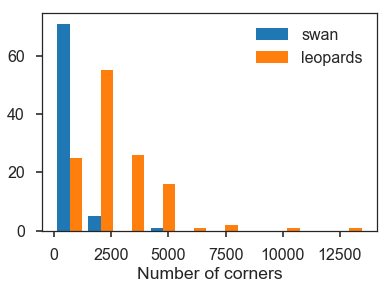

In [20]:
swan_corners, leopards_corners = [], []
for p in category_paths('swan'):
    img = imread(p)
    swan_corners.append(harris_corners(img))
for p in category_paths('leopards'):
    img = imread(p)
    leopards_corners.append(harris_corners(img))

# Empirical Distribution of number of harris corners in swan images and leopard images
plt.hist([swan_corners, leopards_corners], label=['swan', 'leopards']);
plt.xlabel("Number of corners")
plt.legend();
plt.show();

### Difference of Gaussian (DoG) and Determinant of Hessian (DoH) blob detector. 
Referring to http://eric-yuan.me/surf, there are two methods used for feature detection: SIFT (Scale-invariant feature transform) and SURF (Speeded Up Robust Features). In Sift method, we use Difference of Gaussian (DoG) to build the image pyramid, and in Surf, we simply use an integer approximation to the determinant of Hessian blob detector. 

In [21]:
def doh_dog_blobs(img):
    """
    Calculate the number of blobs in an image using the
    determinant of Hessian (DoH) and difference of Gaussians (DoG)
    """
    if img.shape[-1] == 3:
        img = rgb2gray(img)
    n_blob_doh = len(blob_doh(img))
    n_blob_dog = len(blob_dog(img))
    blob_diff = n_blob_doh - n_blob_dog
    return n_blob_doh, n_blob_dog, blob_diff

## Feature Extraction
   
With assistances of the above complementary functions, we can now extract 50 features from all of the images, though some of features might not be used in constructing the final classifier due to weaker relationships or repetitions. 

We use multiprocessing for speed ups. Code adapted from lecture 08_Parallelism.

In [22]:
def extract_features(image_path_list):
    """Extract pre-designed features from all given training images"""
    feature_list = []
    for image_path in image_path_list:
        try:
            img = imread(image_path)
        except:
            continue
        # Feature 1 - Image array size
        image_size = img_size(img)
        # Feature 2 - Image orientation (portrait or landscape)
        aspect_ratio = orientation(img)
        # Feature 3, 4, 5 - Mean, Standard Deviation and Range of Red Channel
        red_mean, red_std, red_range = color_stats(img, 'r')
        # Feature 6, 7, 8 - Mean, Standard Deviation and Range of Green Channel
        green_mean, green_std, green_range = color_stats(img, 'g')
        # Feature 9, 10, 11 - Mean, Standard Deviation and Range of Blue Channel
        blue_mean, blue_std, blue_range = color_stats(img, 'b')
        # Feature 12, 13, 14 - Mean, Standard Deviation and Range of Image itself
        image_mean, image_std, image_range = color_stats(img, 'z')
        # Feature 15 - Ratio of mean values of Red & Green Channels
        red_green_ratio = color_ratio(img, 'r', 'g')
        # Feature 16 - Ratio of mean values of Green & Blue Channels
        green_blue_ratio = color_ratio(img, 'g', 'b')
        # Feature 17 - Ratio of mean values of Blue & Red Channels
        blue_red_ratio = color_ratio(img, 'b', 'r')
        # Feature 18 - Difference of mean values of Red & Green Channels
        red_green_diff = color_diff(img, 'r', 'g')
        # Feature 19 - Difference of mean values of Green & Blue Channels
        green_blue_diff = color_diff(img, 'g', 'b')
        # Feature 20 - Difference of mean values of Blue & Red Channels
        blue_red_diff = color_diff(img, 'b', 'r')
        # Feature 21 - Correlation of Red & Green values
        red_green_corr = color_xcorr(img, 'r', 'g')
        # Feature 22 - Correlation of Green & Blue values
        green_blue_corr = color_xcorr(img, 'g', 'b')
        # Feature 23 - Correlation of Blue & Red values
        blue_red_corr = color_xcorr(img, 'b', 'r')
        # Feature 24, 25 - Fraction of saturated pixels (in greyscale)
        below, above = saturation(img)
        # Feature 26, 27, 28, 29 - Positions of maximum and minimum values in Red Channel
        red_min_x, red_min_y, red_max_x, red_max_y = min_max_color_position(img, 'r')
        # Feature 30, 31, 32, 33 - Positions of maximum and minimum values in Green Channel
        green_min_x, green_min_y, green_max_x, green_max_y = min_max_color_position(img, 'g')
        # Feature 34, 35, 36, 37 - Positions of maximum and minimum values in Blue Channel
        blue_min_x, blue_min_y, blue_max_x, blue_max_y = min_max_color_position(img, 'b')
        # Feature 38, 39, 40, 41 - Positions of maximum and minimum values of the image array
        image_min_x, image_min_y, image_max_x, image_max_y = min_max_color_position(img, 'z')
        # Feature 42 - Distance between minimum and maximum value in Red Channel
        red_dist = min_max_distance(img, 'r')
        # Feature 43 - Distance between minimum and maximum value in Green Channel
        green_dist = min_max_distance(img, 'g')
        # Feature 44 - Distance between minimum and maximum value in Blue Channel
        blue_dist = min_max_distance(img, 'b')
        # Feature 45 - Distance between minimum and maximum value in Red Channel
        image_dist = min_max_distance(img, 'z')
        # Feature 46 - Number of harris corners
        n_corners = harris_corners(img)
        # Feature 47, 48, 49 - Number of blobs using DoH, DoG and their differences
        n_blob_doh, n_blob_dog, blob_diff = doh_dog_blobs(img)
        # Feature 50 - Number of blobs per corner
        if n_corners == 0:
            blob_per_corner = -1.
        else:
            blob_per_corner = np.mean(np.array([n_blob_doh, n_blob_dog]))/n_corners
        # Select the most relevant 36 features
        feature = [image_path,
                   image_size, # Feature 1
                   aspect_ratio, # Feature 2
                   red_mean, red_std, # Feature 3, 4
                   green_mean, green_std, # Feature 6, 7
                   blue_mean, blue_std, # Feature 9, 10
                   image_mean, image_std, # Feature 12, 13
                   red_green_ratio, green_blue_ratio, blue_red_ratio, # Feature 15, 16, 17
                   red_green_diff, green_blue_diff, blue_red_diff, # Feature 18, 19, 20
                   red_green_corr, green_blue_corr, blue_red_corr, # Feature 21, 22, 23
                   below, above, # Feature 24, 25
                   red_min_x, red_max_x, # Feature 26, 28
                   green_min_x, green_max_x, # Feature 30, 32
                   blue_min_x, blue_max_x, # Feature 34, 36
                   image_min_x, image_max_x, # Feature 38, 40
                   red_dist, green_dist, blue_dist, image_dist, # Feature 42, 43, 44, 45
                   n_corners, # Feature 46
                   n_blob_doh, n_blob_dog, blob_diff, # Feature 47, 48, 49
                   blob_per_corner # Feature 50
                  ]
        feature_list.append(feature)
    return feature_list

In [23]:
def split_seq(seq, size):
    """Complementary function for multiprocessing; to equally split tasks/seqs"""
    new_seq = []
    splitsize = 1.0/size*len(seq)
    for i in range(size):
        new_seq.append(seq[int(round(i*splitsize)):int(round((i+1)*splitsize))])
    return new_seq

In [24]:
def extract_parallel(image_paths, write=True):
    """
    Use multiprocessing for speed ups.
    Adapt from examples given in lecture 08_Parallelism.
    """
    numprocessors = cpu_count()
    split_image_paths = split_seq(image_paths, numprocessors)
    p = Pool(numprocessors)
    result = p.map_async(extract_features, split_image_paths)
    poolresult = result.get()
    combined_result = []
    for single_proc_result in poolresult:
        for single_image_result in single_proc_result:
            combined_result.append(single_image_result)
    if write:
        pickle.dump(combined_result, open('features.pkl', 'wb'))
    return combined_result

### Now we extract the features from images.
Since we have chose to use multiprocessing, and I do not understand how does 'tqdm', the interaction process checkbar extension, work with multiprocessing, I did not write any print comment to show which part/stage are the workers working on (like webscrapping data from airport XXX in HW5). It should still yield a general sense on the expected total length of running time.

**<font color=red>NOTE: Running the following cell would take a while!<font>**

In [25]:
extract_parallel(image_paths=image_paths);

## Classifier Construction & Training

Since we have 50 categories of images and each category has different number of images, we want to make sure that we do not overtrain the classifier on categories with more images, nor do we want to train it insufficiently. 

The smallest categories - galaxy & skunk - have 54 images. In addition, most categories have ~60 to ~80 images. If we split the dataset by 90/10, 45 would be a good amount. After randomly selecting 45 images from each category for training, remained images would be used for validation test. 

In [26]:
def train_test_split(features, n=45):
    counts = {}
    i = 0
    train_X, train_y, test_X, test_y = [], [], [], []
    rand_ind = np.arange(0, len(features))
    np.random.shuffle(rand_ind)
    for i in rand_ind:
        f = features[i][1:]
        l = label_from_path(features[i][0])
        try:
            counts[l] += 0
        except KeyError:
            counts[l] = 0
        if counts[l] < n:
            train_X.append(f)
            train_y.append(l)
            counts[l] += 1
        else:
            test_X.append(f)
            test_y.append(l)
            counts[l] += 1
    return np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y), counts

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
def random_forest(train_X, train_y):
    """Train a random forest classifier."""
    clf = RandomForestClassifier(n_estimators=1000, verbose=1, n_jobs=-1)
    clf.fit(train_X, train_y)
    return clf

In [29]:
features = pickle.load(open('features.pkl', 'rb'))
n = 45
train_X, train_y, test_X, test_y, counts = train_test_split(features, n=n)
rf = random_forest(train_X, train_y)
pickle.dump(rf, open('random_forest.pkl', 'wb'))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


## Classifier Evaluation
Below, we would evalute the performance and accuracy of the previously constructed Random Forest Classifier, by computing its accuracy and confusion matrix, creating a heat map for accuracies for each category, finding out the importancies of all 36 features, and comparing our classifier with random guessing.

In [30]:
rf = pickle.load(open('random_forest.pkl', 'rb'))

### Confusion Matrix & Heat Map

We should expect a diagonal heat map if the classifier works well. By computing the confusion matrices and plot them into a heat map, we can justify if our classifier is great enough. 

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
def plot_confusion_matrix(matrix, classes):
    """Plots the confusion matrices as a heat map"""
    plt.figure(figsize=(15, 15))
    matrix = matrix / matrix.sum(axis=1)
    plt.imshow(cm, interpolation='nearest', cmap='viridis')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation='vertical', size=10)
    plt.yticks(tick_marks, classes, size=10)
    plt.ylabel('True Category')
    plt.xlabel('Predicted Category')

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


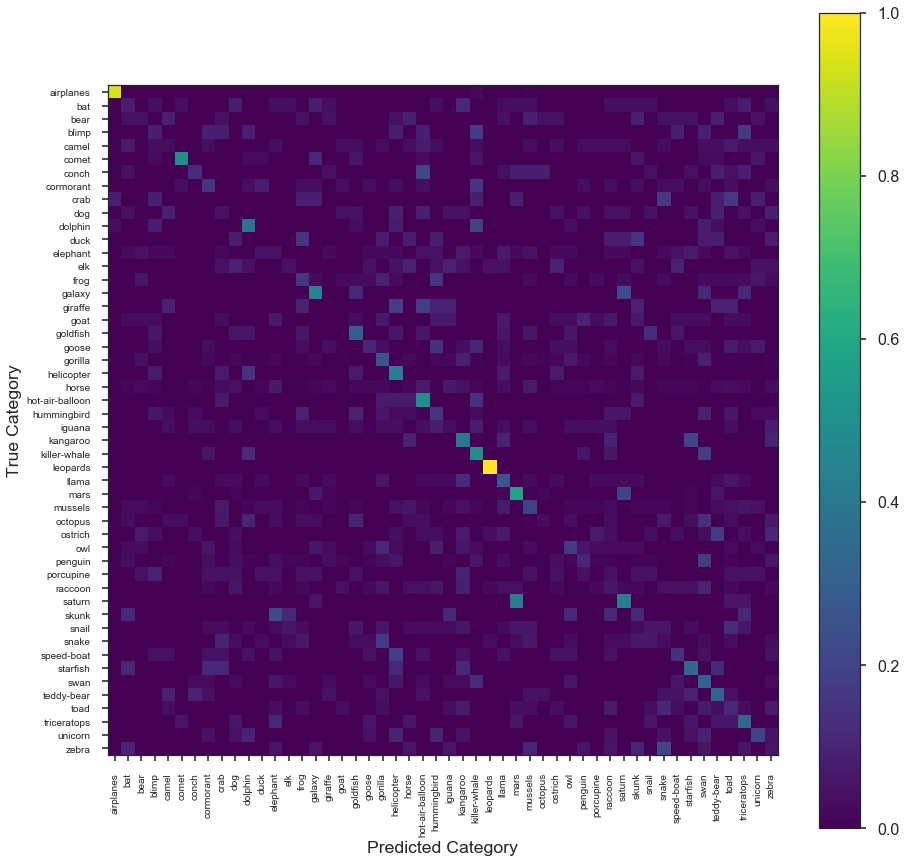

In [33]:
weights = np.array([1./(counts[t]-n) for t in test_y])
cm = confusion_matrix(test_y, rf.predict(test_X), sample_weight=weights)
classes = np.unique(test_y)
plot_confusion_matrix(cm, classes)

From the heat map above, we can see that the classifier we constructed is not great enough, for a number of categories but not all. There are several noticable yet common misclassifications, defined by the high values (light/yellow-er color) not on the diagonal. This map delivers us a general sense on what "patterns" of categorization can more frequently result in misclassifications.

For instance, using our classifier, 'killer-whale' seems to be quite difficult to predict since there are several other catogaries that would confuse the classifier: "swan", "hot-ait-balloon", "goose", "dolphin", "cormorant" and "blimp". "Swan" is also easily confused with "raccoon", "penguin", "octopus" and "killer-whale". 'Comet' can occasionally be categorized as 'galaxy', and 'saturn' and 'mars' are quite frequently misclassified as each other.

### Feature Importance

One of the benefits of random forest classifiers is that the 'feature_importance_" extension of it in sklearn yields the importance of each feature used in the classification. We find the importances and visualize the value by making a barplot.

In [34]:
feature_names = [
                "Image Size", "Aspect Ratio", "Red Mean", "Red Contrast", # Feature 1, 2, 3, 4
                "Green Mean", "Grean Contrast", "Blue Mean", "Blue Contrast", # Feature 6, 7, 9, 10
                "Image Tone Mean", "Image Tone Contrast", # Feature 12, 13
                # Feature 15, 16, 17
                "Red-Green Ratio", "Green-Blue Ratio", "Blue-Red Ratio",
                # Feature 18, 19, 20
                "Red-Green Difference", "Green-Blue Difference", "Blue-Red Difference",
                # Feature 21, 22, 23
                "Red-Green Correlation", "Green-Blue Correlation", "Blue-Red Correlation",
                "Saturation below thresh", "Saturation above thresh", # Feature 24, 25
                "Red Min Value Location", "Red Max Value Location", # Feature 26, 28
                "Green Min Value Location", "Green Max Value Location", # Feature 30, 32
                "Blue Min Value Location", "Blue Max Value Location", # Feature 34, 36
                "Image Min Value Location", "Image Max Value Location", # Feature 38, 40
                # Feature 42, 43, 44, 45
                "Red Min-Max Distance", "Green Min-Max Distance", "Blue Min-Max Distance", "Image Min-Max Distance",
                "Num of Corners", # Feature 46
                "Num of Blobs (DoG)", "Num of Blobs (DoH)", "Blob Number Difference", # Feature 47, 48, 49
                "Num of Blobs per corner" # Feature 50
                ]

In [35]:
# Find & Print the feature importances
f_importance = rf.feature_importances_
f_imp_values = np.argsort(f_importance)
features_sorted = np.array(feature_names)[f_imp_values]
print("%25s %25s" % ('Feature Name','Feature Importance'))
print("="*55)
for i in range(len(feature_names)) :
    print("%25s %10s %.5f" % (features_sorted[-1-i],'',np.sort(f_importance)[-1-i]))

             Feature Name        Feature Importance
             Aspect Ratio            0.04630
               Image Size            0.04039
    Red-Green Correlation            0.02995
           Num of Corners            0.02866
     Blue-Red Correlation            0.02796
               Green Mean            0.02774
     Red-Green Difference            0.02741
                 Red Mean            0.02718
         Green-Blue Ratio            0.02713
  Num of Blobs per corner            0.02696
   Green-Blue Correlation            0.02692
          Red-Green Ratio            0.02678
          Image Tone Mean            0.02650
  Saturation below thresh            0.02648
             Red Contrast            0.02625
                Blue Mean            0.02622
    Green-Blue Difference            0.02614
     Red Min-Max Distance            0.02601
            Blue Contrast            0.02576
      Blue-Red Difference            0.02561
           Blue-Red Ratio            0.02557
   

In [36]:
# Create a dataframe for features and their corresponding values for plotting
import pandas as pd 
d = {"Feature Names" : feature_names, "Feature Importances" : f_importance}
feat_impt = pd.DataFrame(data=d)
sorted_feat = feat_impt.sort_values('Feature Importances', ascending = False)

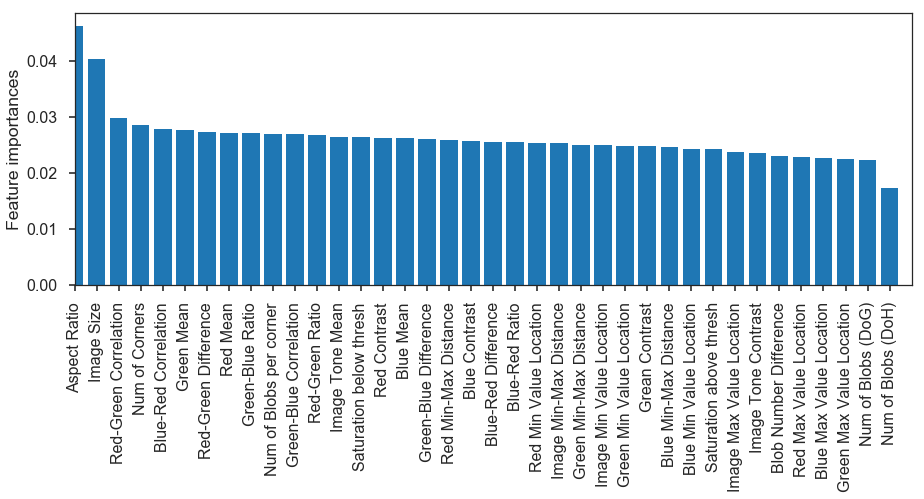

In [37]:
ind = np.arange(len(feature_names))
plt.figure(figsize=(15, 5))
plt.bar(ind, sorted_feat["Feature Importances"])
plt.xlim(0, len(feature_names))
plt.ylabel('Feature importances')
plt.xticks(ind, sorted_feat["Feature Names"], rotation='vertical');

The 3 most important features are the Aspect Ratio, Image (Array) Size and the Red-Green (mean values') correlations, though there's a significant drop in importances from Image Size to the Red-Green Correlation, which is just slightly better than the rest features. 

The 3 least important features are the Number of Blobs (DoH), Number of Blobs (DoG) and Location of Maximum Value in Green Channel (where that in Red & Blue Channel have very close values). 

**<font color=blue>Place for Improvement<font>** 
: The bar for "Aspect Ratio" is cut into half since x-axis starts with number 0. Shifting the range from 0 - 35 to -1 - 34 might resolve this issue, though doing so would lead to a value range error in my method.

### Accuracy Scores & Comparison to Random Guessing
First we find the overall/average accuracy for our Random Forest Classifer then look in the specific accuracy for each category. In order to compare the performance of our classifer with Random Guessing, we need to construct another Classifier using DummyClassifier from sklearn. 

#### Accuracy Scores
The average accuracy for our classifier is ~39%. For some categories, the classifier performs particularly well (>50% accuracy), including 'airplanes', 'leopards' and 'mars', and for some the classifier works decently such as 'comet', 'hot-ait-balloon' and 'killer-whale'.

In [38]:
rf.score(test_X, test_y)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.39217652958876631

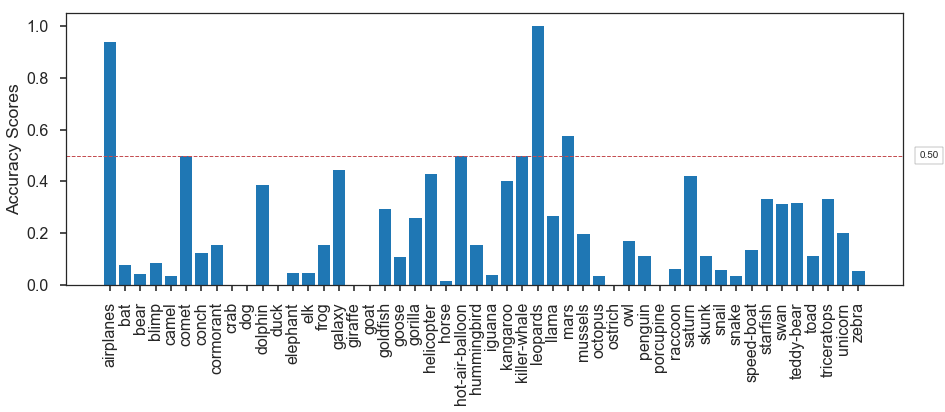

In [39]:
scores = []
rf.set_params(verbose=0)
for cat in sorted(counts.keys()):
    cat_X = test_X[np.where(test_y == cat)]
    weights = np.ones(len(cat_X))/len(cat_X)
    scores.append(rf.score(test_X[np.where(test_y == cat)],
                           test_y[np.where(test_y == cat)],
                           sample_weight=weights))

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ind = np.arange(len(sorted(counts.keys())))
ax.bar(ind, scores)
ax.axhline(y = 0.5, linewidth = 1, linestyle = '--', color='r')
ax.text(1.02, 0.5, "0.50", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=ax.get_yaxis_transform())
plt.xticks(ind, sorted(counts.keys()), rotation='vertical')
plt.ylabel('Accuracy Scores')
plt.show()

The barplot for each category's accuracy is purposefully not sorted by the accuracy scores, as having the 50 categories ordered by alphabets gives the most conviences for the readers to refer back to the given training image sets. 

#### Comparing to Random Guessing
In order to compare the performance of the Random Forest Classifier with that of Random Guessing, we need to first construct and training a Random Guessing Classifier, based on DummyClassifier. 

In [40]:
from sklearn.dummy import DummyClassifier

In [41]:
def random_guessing(train_X, train_y):
    """Train a random guessing classifier."""
    clf = DummyClassifier(strategy="prior", random_state=42)
    clf.fit(train_X, train_y)
    return clf

In [42]:
features = pickle.load(open('features.pkl', 'rb'))
n = 45
train_X, train_y, test_X, test_y, counts = train_test_split(features, n=n)
rg = random_guessing(train_X, train_y)
pickle.dump(rg, open('random_guessing.pkl', 'wb'))

In [43]:
rg = pickle.load(open('random_guessing.pkl', 'rb'))

In [44]:
rg.score(test_X, test_y)

0.24473420260782347


**Conclusion** 
: Comparing to our Random Forest Classifier's accuracy : 0.39218, the Random Guessing Classifier has a lower accuracy score 0.24473, leaving our Classifier (slightly) better than Random Guessing.

## Final Classifier for Future Use 

In [45]:
def run_final_classifier(img_dir, rf_path='./random_forest.pkl', out='validation_results.txt'):
    """
    The all-in-one function to classify/categorize any directory with images into the 50 given categories.
    """
    # Extract features
    image_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir)]
    print('Extracting features')
    features = extract_parallel(image_paths, write=False)
    # Predict classes
    print('Loading random forest model')
    rf = pickle.load(open(rf_path, 'rb'))
    print('Predicting classes')
    features = np.array(features)
    labels = [os.path.basename(f) for f in features[:, 0]]
    features = features[:, 1:]
    pred_labels = rf.predict(features)
    # Write to file
    print('File saved as', out)
    np.savetxt(out, np.array(list(zip(*[labels, pred_labels]))), fmt='%s', header='filename predicted_class\n'+'-'*30)

In [46]:
# Example of Use
test_case = run_final_classifier(img_dir='./50_categories/galaxy/')

Extracting features
Loading random forest model
Predicting classes


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.1s finished


File saved as validation_results.txt


Using category 'galaxy' as the test, whose accuracy score is **below** 0.50 according to the barplot above, by examining and reviewing the validation output file, we find 5 discrepancies leaving the test-case accuracy as:

In [47]:
print(round((54 - 5) / 54 * 100, 5), '%')

90.74074 %
